# Pipline

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
import glob

tangle_data = pd.read_excel(
    "OMSK-PKN_GP1.1_NEW.xlsx",
    sheet_name="Фасады_Секции по файлу",
    skiprows=7,
    header=0 
)

#=== Clean tangle data
tangle_data = tangle_data[['Утвержденный номер','Справочник','Номер позиции', 'Id']]
tangle_data = tangle_data[tangle_data['Справочник'] == '2. Работы строительно-монтажные NEW']

tangle_data['section'] = tangle_data['Утвержденный номер'].str.split('.').str[0:2].str.join('.')
# tangle_data = tangle_data[tangle_data['section'] != tangle_data['Номер позиции']]
section_files = {
    "1.1":'revit_params_OMSK-PKN_GP1.1_01_AR.csv',
    "1.2":'revit_params_OMSK-PKN_GP1.1_02,08_AR.csv',
    "1.3":'revit_params_OMSK-PKN_GP1.1_03,05,07_AR.csv',
    "1.4":'revit_params_OMSK-PKN_GP1.1_04_AR.csv',
    "1.5":'revit_params_OMSK-PKN_GP1.1_03,05,07_AR.csv',
    "1.6":'revit_params_OMSK-PKN_GP1.1_06_AR.csv',
    "1.7":'revit_params_OMSK-PKN_GP1.1_03,05,07_AR.csv',
    "1.8":'revit_params_OMSK-PKN_GP1.1_02,08_AR.csv',
    "1.9":'revit_params_OMSK-PKN_GP1.1_09_AR.csv',
}
tangle_data['section'] = tangle_data['section'].map(section_files)

tangle_data.dropna(inplace=True)
tangle_data.drop(columns=['Утвержденный номер', 'Справочник'], inplace=True)

tangle_data.rename(columns={'Номер позиции': "Position", "Id":"ElementId"}, inplace=True)
tangle_data['ElementId'] = tangle_data['ElementId'].astype('int64')
id_groups = tangle_data.groupby('ElementId')['Position'].apply(list).reset_index()

#==== Concat all csv
csv_files = glob.glob('*.csv')
revit_data = pd.DataFrame()
for file in csv_files:
    if "revit_params_OM" in file:
        tangle_data_slice = tangle_data[tangle_data['section'] == file]
        df = pd.read_csv(file)

        marged_df = tangle_data_slice.merge(df, left_on='ElementId', right_on='ElementId')
        revit_data = pd.concat([revit_data, marged_df], sort=False, axis=0)
del revit_data['section']

#=== marged_df split and clear
target_cols = ['ElementId', 'Position']
X_train = revit_data.drop(columns=target_cols, axis=1)
X_df_to_drop = ['Марка', 'Граница помещения','Комментарии','Линия привязки','Маркировка типоразмера','ADSK_Этаж', 'Цвет штриховки при низкой детализации', 'ADSK_Номер секции']
X_train.drop(columns=X_df_to_drop, inplace=True)
X_df_to_drop2 =  X_train.columns[X_train.columns.str.contains('PS_Секция')]
X_train.drop(columns=X_df_to_drop2, inplace=True)

X_train['Зависимость снизу'] = X_train['Зависимость снизу'].str.split('(', expand=True)[0]
X_train['Зависимость сверху'] = X_train['Зависимость сверху'].str.split('(', expand=True)[0]
X_train['Уровень'] = X_train['Уровень'].str.split('(', expand=True)[0]

#=== Matrix of targets 
y_train = revit_data[target_cols]
y_train = pd.get_dummies(y_train, columns=['Position'])
del y_train['ElementId']
y_train = y_train.astype(np.int8)
y_train.reset_index(inplace=True, drop=True)
constant_cols = X_train.columns[X_train.nunique() <= 1]
X_train.drop(columns=constant_cols, inplace=True)
X_train.reset_index(inplace=True, drop=True)
X_train

C:\Users\homer\AppData\Local\Temp\ipykernel_21208\802491315.py:47: DtypeWarning: Columns (58,83,100,101,106,112,116,119,121,123,124,142,143,149,150,152,156,157,164,167,170,175,177,183,185,186,187,188,189,190,194,196,198,204,207,211,212,215,231,238,239,249,253,286,318,319,323,331,332,333,339,344,345,346,347,348,403,407,408,409,410,432,448,450,480,483,488,489,490,491,492,493,494,495,498,499,500,572,591,592,595,596,600,601,665,673,675,676,678,680,696,697,698,699,700,701,702,703,704,705,706,707,711,712,713,714,715,716,726,727,730,731,732,733,734,735,736,740,741,742,743,744,745,746,747,749,751,759,760,762,768,777,778,779,780,782,809,810,833,837,858,868,869,870,871,872,875,876,887,888,889,890,891,892,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,958,973,974,975,976,983,993,994,995,996,1010,1013,1014,1015,1019,1028,1030,1031,1032,1033,1040,1041,1042,1043,1044,1045,

,#_Высота отделки,#_Ширина откоса,ADSK_Группирование,ADSK_Зона,ADSK_Материал,ADSK_Основной материал элемента,ADSK_Примечание,ADSK_Размер_Высота,ADSK_Размер_Длина,ADSK_Размер_Площадь,...,яНахлестОтделкиНиз,яОткосВерхний,яОткосЛевый,яОткосПравый,яУдлинениеОткосаЛевого(вверх),яУдлинениеОткосаПравого(вверх),Отметка низа сердцевины,Отметка низа съемки,Отметка сердцевины верха,Отметка съемки верха
0,NaN,NaN,Фасад,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,Фасад,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,Фасад,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,Фасад,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,Фасад,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22067,NaN,NaN,Фасад,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22068,NaN,NaN,Фасад,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22069,NaN,NaN,Фасад,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22070,NaN,NaN,Фасад,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---
Векторизация категориальных переменных

In [2]:
import re
import unidecode
from pymorphy3 import MorphAnalyzer

morph = MorphAnalyzer()

def _clean_text(text: str) -> str:
    if not isinstance(text, str) or text.strip() == "":
        return ""
    
    # text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'(\d+)-[йя]', r'\1', text)
    text = re.sub(r'\s+', ' ', text)
    # text = unidecode.unidecode(text)
    text = text.lower().strip()
    
    return text

def _lemmatize_text(text: str) -> str:
    if not text:
        return ""
    tokens = text.split()
    lemmatized = []
    for token in tokens:
        parsed = morph.parse(token)
        lemma = parsed[0].normal_form

        lemmatized.append(lemma)
    return " ".join(lemmatized)

import re

cats = X_train.select_dtypes('object').columns.to_list()

for col in cats:
    X_train[col] = X_train[col].apply(_clean_text).apply(_lemmatize_text)
X_train.replace("", np.nan, inplace=True)

In [3]:
print(X_train.shape)
X_train.isna().sum()

(22072, 113)


#_Высота отделки                   22000
#_Ширина откоса                    21943
ADSK_Зона                          18169
ADSK_Материал                      13691
ADSK_Основной материал элемента    22046
                                   ...  
яУдлинениеОткосаПравого(вверх)     21242
Отметка низа сердцевины            21624
Отметка низа съемки                21624
Отметка сердцевины верха           21624
Отметка съемки верха               21624
Length: 113, dtype: int64

---

попытка выбрать только релевантные признаки + выровнять классы

                       count
Position                    
004.014.033.006.001.1     32
004.014.033.004.005      304
004.014.033.004.004      304
004.014.033.004.003      304
004.014.033.004.001      304
004.014.033.004.006      304
004.014.033.004.002      748
004.014.033.002.005     1745
004.014.033.002.004     1745
004.014.033.002.002     1745
004.014.033.002.001     1745
004.014.033.002.003     1745
004.014.033.001.002     1751
004.014.033.001.013     2324
004.014.033.001.012     2324
004.014.033.001.008     2324
004.014.033.001.005     2324


C:\Users\homer\AppData\Local\Temp\ipykernel_10076\2890861746.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  sns.barplot(x=data.index, y=data['count'], orient='v').set_xticklabels(data.index, rotation=90)


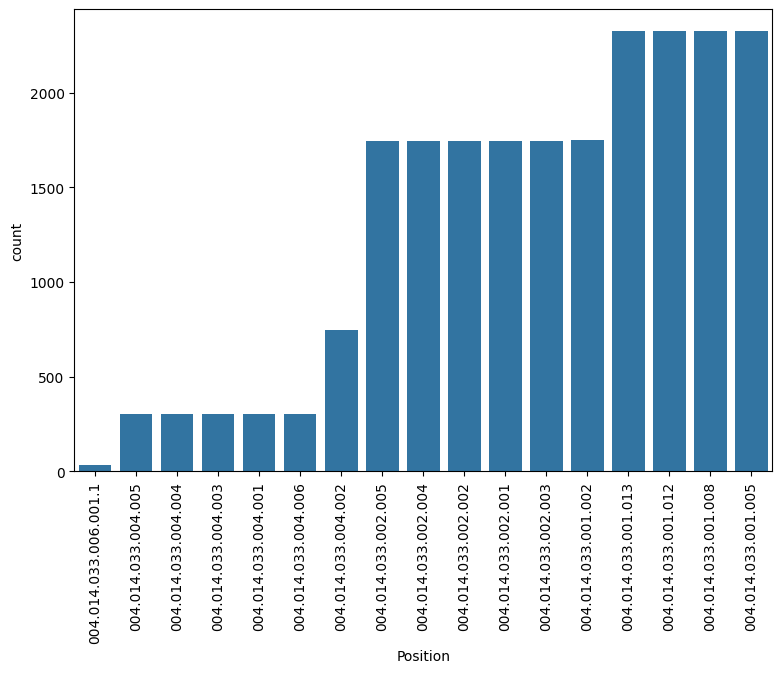

In [4]:
def get_count(labels):
    df = pd.DataFrame(labels, columns=['Position'])
    df['count'] = 1
    return df.groupby('Position').count().sort_values('count')

df = get_count(revit_data)
print(df)
#===== Проверка распределения файлов =====
def show_data(data, min_level=True, max_level=True):
    plt.figure(figsize=(9, 6))
    sns.barplot(x=data.index, y=data['count'], orient='v').set_xticklabels(data.index, rotation=90)
    # if max_level:
    #     plt.axhline(y=1500)
    # if min_level:
    #     plt.axhline(y=100, color='red')
    plt.show()
    
show_data(df)

```H0: Признаки не значимы. H1: признаки значимы (p<0,5) ```
Те параметры, что будут в словаре - являются статистически значимыми

In [ ]:
#=== выравнивение путем выбора одинакового колличества для каждого класса
from scipy.stats import chi2_contingency

stat_params = {}
for y_col in y_train.columns:
    params = []
    y_spl = y_train[y_col]
    y1 = y_spl[y_spl == 1]
    y2 = y_spl[y_spl == 0][:y1.shape[0]]

    y = pd.concat([y1, y2], sort=False, axis=0)
    y_ind = y.index
    X = X_train.iloc[y_ind].copy()

    cons = X.columns[X.nunique() < 1]
    X.drop(columns=cons, inplace=True)

    for col in X.columns:
        contingency_table = pd.crosstab(X[col], y)
        chi2, p, dof, exp = chi2_contingency(contingency_table)

        if p < 0.05:
            params.append(col)

    stat_params[y_col] = params

stat_params

import json
with open('stat_params.json', 'w', encoding='utf-8') as f:
    json.dump(stat_params, f, indent=4, ensure_ascii=False)



In [56]:
#=== выравнивение путем выбора одинакового колличества для каждого класса
from scipy.stats import chi2_contingency

stat_params = {}
for y_col in y_train.columns:
    params = []
    for col in X_train.columns:
        print(y_train[y_col])
        contingency_table = pd.crosstab(X_train[col], y_train[y_col])
        chi2, p, dof, exp = chi2_contingency(contingency_table)

        if p < 0.05:
            params.append(col)

    stat_params[y_col] = params

stat_params


0        1
1        1
2        1
3        1
4        1
        ..
22067    0
22068    0
22069    0
22070    0
22071    0
Name: Position_004.014.033.001.002, Length: 22072, dtype: int8
0        1
1        1
2        1
3        1
4        1
        ..
22067    0
22068    0
22069    0
22070    0
22071    0
Name: Position_004.014.033.001.002, Length: 22072, dtype: int8
0        1
1        1
2        1
3        1
4        1
        ..
22067    0
22068    0
22069    0
22070    0
22071    0
Name: Position_004.014.033.001.002, Length: 22072, dtype: int8
0        1
1        1
2        1
3        1
4        1
        ..
22067    0
22068    0
22069    0
22070    0
22071    0
Name: Position_004.014.033.001.002, Length: 22072, dtype: int8
0        1
1        1
2        1
3        1
4        1
        ..
22067    0
22068    0
22069    0
22070    0
22071    0
Name: Position_004.014.033.001.002, Length: 22072, dtype: int8
0        1
1        1
2        1
3        1
4        1
        ..
22067    0
220

KeyboardInterrupt: 

## Обучение

In [178]:
X_train

,#_Высота отделки,#_Ширина откоса,ADSK_Зона,ADSK_Материал,ADSK_Основной материал элемента,ADSK_Примечание,ADSK_Размер_Высота,ADSK_Размер_Длина,ADSK_Размер_Площадь,ADSK_Размер_Толщина,...,яНахлестОтделкиНиз,яОткосВерхний,яОткосЛевый,яОткосПравый,яУдлинениеОткосаЛевого(вверх),яУдлинениеОткосаПравого(вверх),Отметка низа сердцевины,Отметка низа съемки,Отметка сердцевины верха,Отметка съемки верха
0,NaN,NaN,nan,nan,nan,nan,NaN,NaN,NaN,0.492126,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,nan,nan,nan,nan,NaN,NaN,NaN,0.328084,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,nan,nan,nan,nan,NaN,NaN,NaN,0.492126,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,nan,nan,nan,nan,NaN,NaN,NaN,0.492126,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,nan,nan,nan,nan,NaN,NaN,NaN,0.492126,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22067,NaN,NaN,nan,nan,nan,nan,NaN,NaN,NaN,0.032808,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22068,NaN,NaN,nan,nan,nan,nan,NaN,NaN,NaN,0.032808,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22069,NaN,NaN,nan,nan,nan,nan,NaN,NaN,NaN,0.032808,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22070,NaN,NaN,nan,nan,nan,nan,NaN,NaN,NaN,0.032808,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


STk-fold

In [ ]:
# catb_model = CatBoostClassifier(
#     random_state=42,
#     nan_mode='Max',           # или 'Min' тут хз
#     max_depth=4,              
#     learning_rate=1,        # мб стоит изсенить 
#     n_estimators=500,         # количество деревьев пока 200
#     verbose=100,              # лог каждые 100 итераций, иначе иного инфы
#     scale_pos_weight=None,    # комит, так как не задаю class_weights
#     cat_features=cat_features,# база
#     early_stopping_rounds=15,
#     eval_metric='F1',         # попробую задалансить f1
#     auto_class_weights='Balanced',  # !автомитическая балансировака классов. Имба
# )

# kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# global_f1_score = []
# multi_catb = []
# for i in range(y_train.shape[1]): # 2 в одном, и проверяю устойчивость модели и обучаю сразу. 
#     y_i = y_train.iloc[:, i]

#     f1= 0
#     count = 0
#     for fold, (train, valid) in enumerate(kf.split(X_train, y_i)):
#         print(f"\n--- Fold{i}_{fold + 1} ---")

#         X_train_fold = X_train.iloc[train]
#         X_val_fold = X_train.iloc[valid]
#         y_train_fold = y_i.iloc[train]
#         y_val_fold = y_i.iloc[valid]
        
#         #---Копия модели для каждого фолда
#         model = CatBoostClassifier(**catb_model.get_params())
        
#         #---Обучение
#         model.fit(
#             X_train_fold, y_train_fold,
#             eval_set=(X_val_fold, y_val_fold),
#             # plot=False  # включает графики. Прикольно
#         )
        
#         #---Предсказания
#         y_pred = model.predict(X_val_fold)
#         f1 += f1_score(y_val_fold, y_pred, average='macro')
#         count += 1

#     f1_mean_score = f1/count

#     print(f"\n-----------F1 на валидации: {(f1_mean_score):.4f}\n")
#     # global_f1_score.append(f1_mean_score)

#     # cbc = CatBoostClassifier(**catb_model.get_params())
#     # cbc.fit(X_train, y_i)

#     # multi_catb.append(cbc)

In [4]:
cat_features = []
for col in X_train.select_dtypes('object').columns:
    X_train[col] = X_train[col].astype(str)
    cat_features.append(col)
    X_train[col] = X_train[col].astype('category')

In [5]:
#=== Мультилейбел
from sklearn.multioutput import MultiOutputClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, hamming_loss, f1_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight
import joblib

import json

# CatBoost - Ручное обучение через цикл. На каждый таргет своя модель. + баланс классов
'''
Когда включил график, то заметил что у меня часть моделей ток то быстро обучется, и остальные 100 условных операция идет просто переобучение 
Как я понял есть 2 варианта с этим бороться. Тупо поставить
'''
multi_catb = []
global_params = []

for y_col in y_train.columns:#range(y_train.shape[1]):
    # y_i = y_train.iloc[:, i]
    y_i = y_train[y_col]

    #--- Расчет весов
    # classes = np.unique(y_i)
    # class_weights = compute_class_weight('balanced', classes=classes, y=y_i)
    # class_weight_dict = dict(zip(classes, class_weights))

    #---Выбор статистически значимых признаков
    # params = []
    # y_spl = y_train[y_col]
    # y1 = y_spl[y_spl == 1]
    # y2 = y_spl[y_spl == 0][:y1.shape[0]*2]

    # y = pd.concat([y1, y2], sort=False, axis=0)
    # y_ind = y.index
    # X = X_train.iloc[y_ind].copy()

    # cons = X.columns[X.nunique() < 1]
    # X.drop(columns=cons, inplace=True)

    # for col in X.columns:
    #     contingency_table = pd.crosstab(X[col], y)
    #     chi2, p, dof, exp = chi2_contingency(contingency_table)

    #     if p < 0.05:
    #         params.append(col)
    # params.extend(global_params)
    # stat_params[y_col] = params
    # params = stat_params[col]
    # X = X_extended[params]
    # print(X.shape, y.shape)
    # cat_features = X.select_dtypes('category').columns.to_list()
    X_train_split, X_val, y_train_split, y_val = train_test_split(
        X_train, 
        y_i, 
        test_size=0.33, 
        random_state=42, 
        stratify=y_i
    )

    #---Обучение
    catb_model = CatBoostClassifier(
        # task_type="GPU",
        # devices='0',
        depth=6,
        learning_rate=0.1,
        iterations = 1500,
        verbose=100,
        eval_metric='F1',
        early_stopping_rounds=50,
        # class_weights=class_weight_dict,
        auto_class_weights='Balanced',
        cat_features=cat_features
    )

    cbc = CatBoostClassifier(**catb_model.get_params())
    cbc.fit(X_train_split, y_train_split, plot=True, eval_set=(X_val, y_val))

    multi_catb.append(cbc)

    #---Добавление предсказиний предыдущей модели 
    # p_proba = cbc.predict(X_train_split)
    # proba = cbc.predict_proba(X)
    # print(proba.shape)
    # new_col = f'proba_{col}'
    # global_params.append(new_col)
    # X_extended[new_col] = p_proba

joblib.dump(multi_catb, 'catb.pkl')




MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9887795	test: 0.9891630	best: 0.9891630 (0)	total: 206ms	remaining: 5m 8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9996274962
bestIteration = 9

Shrink model to first 10 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8323189	test: 0.8325777	best: 0.8325777 (0)	total: 60.8ms	remaining: 1m 31s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.839681238
bestIteration = 18

Shrink model to first 19 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8323189	test: 0.8325777	best: 0.8325777 (0)	total: 51.2ms	remaining: 1m 16s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.839681238
bestIteration = 18

Shrink model to first 19 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8323189	test: 0.8325777	best: 0.8325777 (0)	total: 52.2ms	remaining: 1m 18s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.839681238
bestIteration = 18

Shrink model to first 19 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8323189	test: 0.8325777	best: 0.8325777 (0)	total: 63.3ms	remaining: 1m 34s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.839681238
bestIteration = 18

Shrink model to first 19 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8282599	test: 0.8301248	best: 0.8301248 (0)	total: 57.3ms	remaining: 1m 25s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.847231364
bestIteration = 16

Shrink model to first 17 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8282599	test: 0.8301248	best: 0.8301248 (0)	total: 54.5ms	remaining: 1m 21s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.847231364
bestIteration = 16

Shrink model to first 17 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8282599	test: 0.8301248	best: 0.8301248 (0)	total: 82.1ms	remaining: 2m 3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.847231364
bestIteration = 16

Shrink model to first 17 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8282599	test: 0.8301248	best: 0.8301248 (0)	total: 58ms	remaining: 1m 26s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.847231364
bestIteration = 16

Shrink model to first 17 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8282599	test: 0.8301248	best: 0.8301248 (0)	total: 74.2ms	remaining: 1m 51s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.847231364
bestIteration = 16

Shrink model to first 17 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9624179	test: 0.9603709	best: 0.9603709 (0)	total: 90.5ms	remaining: 2m 15s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9640618576
bestIteration = 13

Shrink model to first 14 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9525526	test: 0.9537976	best: 0.9537976 (0)	total: 59.7ms	remaining: 1m 29s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9651283428
bestIteration = 19

Shrink model to first 20 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9618784	test: 0.9614687	best: 0.9614687 (0)	total: 58.3ms	remaining: 1m 27s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9651681765
bestIteration = 24

Shrink model to first 25 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9618784	test: 0.9614687	best: 0.9614687 (0)	total: 59ms	remaining: 1m 28s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9651681765
bestIteration = 24

Shrink model to first 25 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9618784	test: 0.9614687	best: 0.9614687 (0)	total: 61ms	remaining: 1m 31s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9651681765
bestIteration = 24

Shrink model to first 25 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9618784	test: 0.9614687	best: 0.9614687 (0)	total: 66ms	remaining: 1m 38s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9651681765
bestIteration = 24

Shrink model to first 25 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6834604	test: 0.9969711	best: 0.9969711 (0)	total: 79.3ms	remaining: 1m 58s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9970996167
bestIteration = 3

Shrink model to first 4 iterations.


['catb.pkl']

In [43]:
#=== Мультикласс 
target_cols = ['ElementId', 'Position']
X_train = revit_data.drop(columns=target_cols, axis=1)
X_df_to_drop = ['Марка', 'Граница помещения','Комментарии','Линия привязки','Маркировка типоразмера','ADSK_Этаж', 'Цвет штриховки при низкой детализации', 'ADSK_Номер секции','ADSK_Группирование']
X_train.drop(columns=X_df_to_drop, inplace=True)
X_df_to_drop2 =  X_train.columns[X_train.columns.str.contains('PS_Секция')]
X_train.drop(columns=X_df_to_drop2, inplace=True)

X_train['Зависимость снизу'] = X_train['Зависимость снизу'].str.split('(', expand=True)[0]
X_train['Зависимость сверху'] = X_train['Зависимость сверху'].str.split('(', expand=True)[0]
X_train['Уровень'] = X_train['Уровень'].str.split('(', expand=True)[0]

#=== Matrix of targets 
y_train = revit_data[target_cols]
# y_train = pd.get_dummies(y_train, columns=['Position'])
del y_train['ElementId']
# y_train = y_train.astype(np.int8)
y_train.reset_index(inplace=True, drop=True)
constant_cols = X_train.columns[X_train.nunique() <= 1]
X_train.drop(columns=constant_cols, inplace=True)
X_train.reset_index(inplace=True, drop=True)
X_train

cat_features = []
for col in X_train.select_dtypes('object').columns:
    X_train[col] = X_train[col].astype(str)
    cat_features.append(col)
    X_train[col] = X_train[col].astype('category')

from sklearn.multioutput import MultiOutputClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, hamming_loss, f1_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight
import joblib

import json

# CatBoost - Ручное обучение через цикл. На каждый таргет своя модель. + баланс классов
'''
Когда включил график, то заметил что у меня часть моделей ток то быстро обучется, и остальные 100 условных операция идет просто переобучение 
Как я понял есть 2 варианта с этим бороться. Тупо поставить
'''
multi_catb = []

# for i in range(y_train.shape[1]):
#     y_i = y_train.iloc[:, i]

#     classes = np.unique(y_i)
#     class_weights = compute_class_weight('balanced', classes=classes, y=y_i)
#     class_weight_dict = dict(zip(classes, class_weights))
#     print(class_weight_dict)
# X = X_train
# X = X_train[stat_params[y_train.columns[i]]]
# cat_features = X.select_dtypes('category').columns.to_list()

X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, 
    y_train, 
    test_size=0.33, 
    random_state=42, 
    stratify=y_train
)

catb_model = CatBoostClassifier(
    # task_type="GPU",
    # devices='0',
    depth=3,
    learning_rate=0.1,
    iterations = 500,
    verbose=100,
    # eval_metric='F1',
    early_stopping_rounds=50,
    # class_weights=class_weight_dict,
    auto_class_weights='Balanced',
    cat_features=cat_features
)

cbc = CatBoostClassifier(**catb_model.get_params())
cbc.fit(X_train_split, y_train_split, plot=True, eval_set=(X_val, y_val))

multi_catb.append(cbc)

joblib.dump(multi_catb, 'catb.pkl')



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.6976953	test: 2.6976450	best: 2.6976450 (0)	total: 582ms	remaining: 4m 50s
100:	learn: 1.4648698	test: 1.4762299	best: 1.4762299 (100)	total: 59.3s	remaining: 3m 54s
200:	learn: 1.4072268	test: 1.4510342	best: 1.4510113 (198)	total: 1m 59s	remaining: 2m 57s
300:	learn: 1.3748600	test: 1.4452835	best: 1.4452835 (300)	total: 2m 59s	remaining: 1m 58s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.443413167
bestIteration = 345

Shrink model to first 346 iterations.


['catb.pkl']

In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, hamming_loss, f1_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight
import joblib

import json

# CatBoost - Ручное обучение через цикл. На каждый таргет своя модель. + баланс классов
'''
Когда включил график, то заметил что у меня часть моделей ток то быстро обучется, и остальные 100 условных операция идет просто переобучение 
Как я понял есть 2 варианта с этим бороться. Тупо поставить
'''
multi_catb = []

for i in range(y_train.shape[1]):
    y_i = y_train.iloc[:, i]

    classes = np.unique(y_i)
    class_weights = compute_class_weight('balanced', classes=classes, y=y_i)
    class_weight_dict = dict(zip(classes, class_weights))
    print(class_weight_dict)
# X = X_train
# X = X_train[stat_params[y_train.columns[i]]]
# cat_features = X.select_dtypes('category').columns.to_list()

    X_train_split, X_val, y_train_split, y_val = train_test_split(
        X_train, 
        y_i, 
        test_size=0.33, 
        random_state=42, 
        stratify=y_i
    )

    catb_model = CatBoostClassifier(
        # task_type="GPU",
        # devices='0',
        depth=6,
        learning_rate=0.1,
        iterations = 1500,
        verbose=100,
        eval_metric='F1',
        early_stopping_rounds=50,
        class_weights=class_weight_dict,
        # auto_class_weights='Balanced',
        cat_features=cat_features
    )

    cbc = CatBoostClassifier(**catb_model.get_params())
    cbc.fit(X_train_split, y_train_split, plot=True, eval_set=(X_val, y_val))

    multi_catb.append(cbc)

    joblib.dump(multi_catb, 'catb.pkl')



{0: 0.5430835096697997, 1: 6.302684180468304}
{0: 0.5588414016609277, 1: 4.748709122203098}
{0: 0.5588414016609277, 1: 4.748709122203098}
{0: 0.5588414016609277, 1: 4.748709122203098}
{0: 0.5588414016609277, 1: 4.748709122203098}
{0: 0.542923205588626, 1: 6.324355300859599}
{0: 0.542923205588626, 1: 6.324355300859599}
{0: 0.542923205588626, 1: 6.324355300859599}
{0: 0.542923205588626, 1: 6.324355300859599}
{0: 0.542923205588626, 1: 6.324355300859599}
{0: 0.5069827269386256, 1: 36.30263157894737}
{0: 0.5175389232789346, 1: 14.754010695187166}
{0: 0.5069827269386256, 1: 36.30263157894737}
{0: 0.5069827269386256, 1: 36.30263157894737}
{0: 0.5069827269386256, 1: 36.30263157894737}
{0: 0.5069827269386256, 1: 36.30263157894737}
{0: 0.5007259528130672, 1: 344.875}


In [44]:
import joblib
import json

# Сохранение моделей, cat_features и фичей
# joblib.dump(multi_lgbm, 'lgbm.pkl')
joblib.dump(multi_catb, 'catb.pkl')

with open('features.json', 'w') as f:
    json.dump(X_train.columns.to_list(), f)

print("Модели и метаданные сохранены.")

Модели и метаданные сохранены.


In [45]:
with open('trained_targets.json', 'w') as f:
    json.dump(y_train.columns.to_list(), f)

In [46]:
with open('cat_features.json', 'w') as f:
    json.dump(cat_features, f)

In [47]:
with open('features.json', 'r') as f:
    features = json.load(f)


In [55]:
from sklearn.metrics import accuracy_score, hamming_loss, f1_score

#=== Предсказание вероятностей
# y_pred_proba_lgbm = np.array([clf.predict_proba(X_df)[:, 1] for clf in multi_lgbm.estimators_]).T
# y_pred_proba_ensemble = np.array([clf.predict_proba(X_train)[:, 1] for clf in multi_catb]).T
y_pred_proba_ensemble = cbc.predict_proba(X_train)

# y_pred_proba_ensemble = (y_pred_proba_lgbm + y_pred_proba_catb) / 2

#=== отсечения порогом вероятности 
y_pred_ensemble = (y_pred_proba_ensemble > 0.5).astype(int)

In [50]:
y_train

,Position
0,004.014.033.001.002
1,004.014.033.001.002
2,004.014.033.001.002
3,004.014.033.001.002
4,004.014.033.001.002
...,...
22067,004.014.033.006.001.1
22068,004.014.033.006.001.1
22069,004.014.033.006.001.1
22070,004.014.033.006.001.1


In [56]:
y_pred_ensemble.tolist()

[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0,

In [57]:
from sklearn.metrics import accuracy_score, hamming_loss, f1_score, precision_score, recall_score

#=== Точность по объектам (все метки совпали)
exact_match = accuracy_score(y_train, y_pred_ensemble, normalize=True)

#=== Hamming Accuracy (доля правильно предсказанных меток)
hamming_acc = 1 - hamming_loss(y_train, y_pred_ensemble)

#=== F1, Precision, Recall — с разными типами усреднения
f1_macro = f1_score(y_train, y_pred_ensemble, average='macro')
f1_micro = f1_score(y_train, y_pred_ensemble, average='micro')

precision_macro = precision_score(y_train, y_pred_ensemble, average='macro', zero_division=0)
precision_micro = precision_score(y_train, y_pred_ensemble, average='micro', zero_division=0)

recall_macro = recall_score(y_train, y_pred_ensemble, average='macro', zero_division=0)
recall_micro = recall_score(y_train, y_pred_ensemble, average='micro', zero_division=0)

#=== Метрики
print("Результаты ансамбля LGBM + CatBoost:")
print(f"Macro F1 Score:       {f1_macro:.4f}")
print(f"Micro F1 Score:       {f1_micro:.4f}")
print(f"Macro Precision:      {precision_macro:.4f}")
print(f"Micro Precision:      {precision_micro:.4f}")
print(f"Macro Recall:         {recall_macro:.4f}")
print(f"Micro Recall:         {recall_micro:.4f}")

ValueError: Classification metrics can't handle a mix of multiclass and multilabel-indicator targets

# Проверка на тесовых данных

Интерпретация результатов 

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.preprocessing import MultiLabelBinarizer

test_data = pd.read_excel("KRGN-MK_GP07_Фасады_NEW.xlsx", sheet_name="Фасады_Секции по файлу")

#=== Clean data
test_tangle_data = test_data[['Unnamed: 2', 'Unnamed: 3']]
test_tangle_data = test_tangle_data.dropna()

test_tangle_data = test_tangle_data[test_tangle_data['Unnamed: 2'].str.count(r"\.") > 1]

test_tangle_data.rename(columns={'Unnamed: 2': "Position", "Unnamed: 3":"ElementId"}, inplace=True)
test_tangle_data = test_tangle_data.reset_index(drop=True)
test_tangle_data['ElementId'] = test_tangle_data['ElementId'].astype('int64')

tangle_groups = test_tangle_data.groupby('ElementId')['Position'].apply(list).reset_index()
#==== Concat all csv
import glob
def multi_concat():
    csv_files = glob.glob('*.csv')
    out_df = pd.DataFrame()
    for file in csv_files:
        if "revit_params_KRGN" in file:
            print(file)
            df = pd.read_csv(file)
            
            if out_df.empty:
                out_df = df
            else:
                out_df = pd.concat([out_df, df], sort=False, axis=0)
    
    return out_df

test_revit_data = multi_concat()

"""
по началу я не хотел марджить, и по идее в проде это тоже не понадобится, но что бы сделать 
замеры метрик видимо нужно мерджить, что бы выровнять датасеты. Иначе обьекты и метки будут в разных позициях
что приведет к неправильному расчету метрик
"""



revit_params_KRGN-MK_GP07_AR_01.csv


C:\Users\homer\AppData\Local\Temp\ipykernel_15204\2450841528.py:29: DtypeWarning: Columns (195,220,221,231,234,235,237,240,245,247,253,254,255,258,259,260,262,268,270,271,277,284,286,288,290,314,317,318,319,333,363,364,370,402,403,417,423,424,462,465,477,478,484,509,527,649,673,674,677,678,680,766,767,795,796,797,798,799,800,808,814,815,820,821,822,823,824,825,828,829,830,831,832,833,834,835,836,837,838,864,866,898,899,927,931,979,982,983,984,985,992,997,998,999,1001,1002,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033,1034,1035,1036,1037,1039,1040,1041,1042,1043,1044,1045,1046,1047,1048,1049,1051,1077,1089,1093,1094,1099,1105,1142,1147,1159,1161,1162,1163,1164,1165,1166,1167,1168,1171,1172,1173,1174,1175,1176,1177,1178,1179,1185,1187,1204,1216,1228,1241,1271,1366,1447,1496,1504,1513,1569,1570,1571,1572,1587,1606,1607,1609,1632,1665,1666,1681,1682,1729,1740,1741,1743,1745,1748,1750,175

revit_params_KRGN-MK_GP07_AR_02.csv


C:\Users\homer\AppData\Local\Temp\ipykernel_15204\2450841528.py:29: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,171,172,173,174,177,182,183,185,186,187,188,190,191,192,193,194,195,197,199,201,202,204,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,2

revit_params_KRGN-MK_GP07_AR_03.csv


C:\Users\homer\AppData\Local\Temp\ipykernel_15204\2450841528.py:29: DtypeWarning: Columns (203,230,231,241,246,247,249,252,257,259,266,267,268,271,272,273,275,281,283,284,290,297,299,302,304,328,331,332,333,334,335,341,345,347,348,356,357,358,359,390,391,397,429,430,443,446,452,453,455,505,508,513,514,525,526,532,541,578,596,645,646,647,648,649,650,651,652,653,734,762,763,766,767,769,864,869,871,872,873,901,902,903,904,905,906,914,920,921,926,927,928,929,930,931,934,935,936,937,938,939,940,941,942,943,944,972,975,1015,1016,1044,1048,1096,1099,1100,1102,1103,1106,1111,1118,1119,1120,1122,1123,1125,1126,1127,1128,1129,1130,1131,1132,1133,1134,1135,1136,1137,1138,1139,1140,1141,1142,1143,1144,1145,1146,1147,1148,1149,1150,1151,1152,1153,1154,1155,1156,1157,1158,1160,1161,1162,1163,1164,1165,1166,1167,1168,1169,1170,1172,1198,1210,1214,1215,1216,1217,1222,1228,1269,1274,1281,1287,1289,1290,1291,1292,1293,1294,1295,1296,1299,1300,1301,1302,1303,1304,1305,1306,1307,1313,1315,1332,1346,1361,1

revit_params_KRGN-MK_GP07_AR_04.csv


C:\Users\homer\AppData\Local\Temp\ipykernel_15204\2450841528.py:29: DtypeWarning: Columns (182,214,215,225,230,231,233,236,241,243,249,250,251,254,255,256,258,264,266,267,273,280,282,285,287,288,311,314,315,316,317,318,327,329,332,334,346,347,349,381,388,420,421,437,443,444,446,495,500,501,513,519,528,564,582,634,635,636,637,638,639,640,641,642,726,752,753,756,757,759,844,848,850,851,852,864,881,882,883,884,885,886,894,900,901,907,908,909,910,911,912,915,916,917,918,919,920,921,922,923,924,925,953,955,996,997,1027,1046,1068,1071,1072,1073,1074,1077,1082,1088,1089,1090,1092,1093,1095,1096,1097,1098,1099,1100,1101,1102,1103,1104,1105,1106,1107,1108,1109,1110,1111,1112,1113,1114,1115,1116,1117,1118,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128,1129,1130,1131,1132,1133,1135,1136,1137,1138,1139,1140,1141,1142,1143,1144,1145,1172,1187,1191,1192,1193,1198,1204,1245,1250,1257,1263,1265,1266,1267,1268,1269,1270,1271,1272,1275,1276,1277,1278,1279,1280,1281,1282,1283,1291,1293,1310,1324,1339,

revit_params_KRGN-MK_GP07_AR_05.csv


C:\Users\homer\AppData\Local\Temp\ipykernel_15204\2450841528.py:29: DtypeWarning: Columns (207,208,218,223,224,226,229,234,236,243,244,245,248,249,250,252,258,260,261,267,274,276,279,281,282,305,309,310,311,312,313,322,324,325,333,334,367,368,374,406,407,422,428,429,431,483,488,489,502,508,532,549,597,598,599,600,601,602,603,604,605,684,710,711,714,715,717,805,810,812,813,814,843,844,845,846,847,848,856,861,862,867,868,869,870,871,872,875,876,877,878,879,880,881,882,883,884,885,911,914,950,951,976,995,1022,1025,1026,1027,1028,1029,1032,1036,1042,1043,1044,1046,1047,1049,1050,1051,1052,1053,1054,1055,1056,1057,1058,1059,1060,1061,1062,1063,1064,1065,1066,1067,1068,1069,1070,1071,1072,1073,1074,1075,1076,1077,1078,1079,1080,1081,1083,1084,1085,1086,1087,1088,1089,1090,1091,1092,1093,1120,1132,1136,1137,1138,1139,1144,1145,1151,1180,1192,1193,1197,1204,1210,1212,1213,1214,1215,1216,1217,1218,1219,1222,1223,1224,1225,1226,1227,1228,1229,1230,1236,1238,1254,1266,1281,1295,1329,1426,1506,155

revit_params_KRGN-MK_GP07_AR_06.csv


C:\Users\homer\AppData\Local\Temp\ipykernel_15204\2450841528.py:29: DtypeWarning: Columns (196,197,207,212,213,215,218,219,227,229,236,237,238,241,242,243,245,252,255,256,262,269,271,275,277,278,303,349,350,356,388,389,402,403,455,465,466,477,483,508,527,564,565,566,567,568,569,570,571,576,577,578,579,580,581,582,583,584,664,692,693,696,697,699,795,801,802,830,831,832,833,834,835,843,848,849,854,855,856,857,858,859,862,863,864,865,866,867,868,869,870,871,872,900,903,943,944,968,1013,1016,1017,1018,1019,1020,1023,1028,1029,1036,1037,1038,1040,1041,1043,1044,1045,1046,1047,1048,1049,1050,1051,1052,1053,1054,1055,1056,1057,1058,1059,1060,1061,1062,1063,1064,1065,1066,1067,1068,1069,1070,1071,1072,1073,1074,1075,1076,1077,1079,1080,1081,1082,1083,1084,1085,1086,1087,1088,1089,1116,1131,1132,1133,1134,1139,1140,1146,1187,1188,1192,1200,1208,1209,1210,1211,1212,1213,1214,1215,1218,1219,1220,1221,1222,1223,1224,1225,1226,1232,1233,1234,1250,1264,1279,1292,1325,1426,1508,1557,1566,1578,1613,16

revit_params_KRGN-MK_GP07_AR_07.csv


C:\Users\homer\AppData\Local\Temp\ipykernel_15204\2450841528.py:29: DtypeWarning: Columns (199,200,210,213,214,216,224,226,233,234,235,238,239,240,242,247,248,250,251,257,264,266,268,270,271,294,311,342,343,349,381,382,396,402,403,448,461,465,472,474,510,529,650,676,677,680,681,683,770,771,799,800,801,802,803,804,812,818,819,824,825,826,827,828,829,832,833,834,835,836,837,838,839,840,841,842,868,871,903,904,932,975,978,979,980,981,988,994,995,996,998,999,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033,1034,1036,1037,1038,1039,1040,1041,1042,1043,1044,1045,1046,1073,1085,1089,1094,1100,1138,1143,1155,1157,1158,1159,1160,1161,1162,1163,1164,1167,1168,1169,1170,1171,1172,1173,1174,1175,1181,1183,1200,1212,1224,1237,1267,1363,1444,1493,1501,1510,1564,1565,1566,1567,1583,1604,1605,1606,1629,1668,1669,1686,1687,1734,1744,1745,1747,1750,1754,1757,1758,1759,1761,1762,1763,1771,1

revit_params_KRGN-MK_GP07_AR_08.csv


C:\Users\homer\AppData\Local\Temp\ipykernel_15204\2450841528.py:29: DtypeWarning: Columns (192,193,203,208,209,211,214,219,221,228,229,230,233,234,235,237,243,245,246,252,259,261,264,266,267,290,334,335,341,373,374,387,437,442,443,454,460,485,504,541,542,543,544,545,546,547,548,553,554,555,556,557,558,559,560,561,641,667,668,671,672,674,768,774,775,803,804,805,806,807,808,816,821,822,827,828,829,830,831,832,835,836,837,838,839,840,841,842,843,844,845,872,875,915,916,940,985,988,989,990,991,992,995,1000,1001,1008,1009,1010,1012,1013,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033,1034,1035,1036,1037,1038,1039,1040,1041,1042,1043,1044,1045,1046,1047,1048,1049,1051,1052,1053,1054,1055,1056,1057,1058,1059,1060,1061,1088,1103,1104,1105,1106,1111,1117,1158,1163,1170,1178,1179,1180,1181,1182,1183,1184,1185,1188,1189,1190,1191,1192,1193,1194,1195,1196,1202,1204,1220,1234,1249,1262,1295,1395,1477,1526,1535,1545,1599,1600,1601,1603,1619,1639,1640,16

revit_params_KRGN-MK_GP07_AR_09.csv


C:\Users\homer\AppData\Local\Temp\ipykernel_15204\2450841528.py:29: DtypeWarning: Columns (205,206,216,221,222,224,227,232,234,241,242,243,246,247,248,250,256,258,259,265,272,274,277,279,280,303,306,307,308,309,310,319,321,322,330,331,364,365,371,403,404,419,425,426,428,478,483,484,497,503,527,544,592,593,594,595,596,597,598,599,600,679,705,706,709,710,712,799,804,806,807,808,836,837,838,839,840,841,849,854,855,860,861,862,863,864,865,868,869,870,871,872,873,874,875,876,877,878,904,907,943,944,969,988,1015,1018,1019,1020,1021,1024,1028,1034,1035,1036,1038,1039,1041,1042,1043,1044,1045,1046,1047,1048,1049,1050,1051,1052,1053,1054,1055,1056,1057,1058,1059,1060,1061,1062,1063,1064,1065,1066,1067,1068,1069,1070,1071,1072,1073,1075,1076,1077,1078,1079,1080,1081,1082,1083,1084,1085,1112,1124,1128,1129,1130,1135,1141,1170,1182,1187,1194,1200,1202,1203,1204,1205,1206,1207,1208,1209,1212,1213,1214,1215,1216,1217,1218,1219,1220,1226,1228,1244,1256,1271,1285,1319,1416,1496,1546,1555,1564,1618,161

revit_params_KRGN-MK_GP07_AR_10.csv


C:\Users\homer\AppData\Local\Temp\ipykernel_15204\2450841528.py:29: DtypeWarning: Columns (184,216,217,227,232,233,235,243,245,251,252,253,256,257,258,260,266,268,269,275,282,284,287,289,290,313,316,317,318,319,320,327,328,330,331,339,340,342,372,379,411,412,427,433,434,436,483,488,489,501,505,514,550,567,617,618,619,620,621,622,623,624,625,705,731,732,735,736,738,828,832,834,835,836,848,865,866,867,868,869,870,878,884,885,890,891,892,893,894,895,898,899,900,901,902,903,904,905,906,907,908,936,938,979,980,1009,1028,1050,1053,1054,1055,1056,1059,1064,1070,1071,1072,1074,1075,1077,1078,1079,1080,1081,1082,1083,1084,1085,1086,1087,1088,1089,1090,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100,1101,1102,1103,1104,1105,1106,1107,1108,1109,1110,1112,1113,1115,1116,1117,1118,1119,1120,1121,1122,1123,1124,1151,1166,1169,1170,1171,1176,1182,1223,1228,1235,1241,1243,1244,1245,1246,1247,1248,1249,1250,1253,1254,1255,1256,1257,1258,1259,1260,1261,1267,1269,1286,1300,1315,1329,1365,1463,1543,1593

'\nпо началу я не хотел марджить, и по идее в проде это тоже не понадобится, но что бы сделать \nзамеры метрик видимо нужно мерджить, что бы выровнять датасеты. Иначе обьекты и метки будут в разных позициях\nчто приведет к неправильному расчету метрик\n'

In [11]:
#=== Marge
# tangle_groups = tangle_groups.sample(frac=1, random_state=42).reset_index()
# del tangle_groups['index']
test_marged_df = tangle_groups.merge(test_revit_data, left_on='ElementId', right_on='ElementId')
# test_marged_df = test_marged_df.sample(frac=1, random_state=42).reset_index()

~~Преобразования датафреймов. y - tangle_groups, x - test_revit_data~~

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer
import json

#=== marged_df split and clear
target_cols = ['ElementId', 'Position']
test_ids = test_marged_df['ElementId'].copy()
X = test_marged_df.drop(columns=target_cols, axis=1)
to_drop = ['Марка', 'Граница помещения','Комментарии','Линия привязки','Маркировка типоразмера','ADSK_Этаж', 'Цвет штриховки при низкой детализации']
X.drop(columns=to_drop, inplace=True)
X['Зависимость снизу'] = X['Зависимость снизу'].str.split('(', expand=True)[0]
X['Зависимость сверху'] = X['Зависимость сверху'].str.split('(', expand=True)[0]
X['Уровень'] = X['Уровень'].str.split('(', expand=True)[0]

y = test_marged_df[target_cols]

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y_fit = mlb.fit_transform(y['Position'])
y = pd.DataFrame(y_fit, columns=mlb.classes_,index=y['ElementId'])
y = y.add_prefix('Target_')

with open('features.json', 'r') as f:
    features = json.load(f)

#=== Выбор только нужных фичей
X = X[X.columns.intersection(features)]

# constant_cols = X.columns[X.nunique() <= 1]
# X = X.drop(columns=constant_cols)
# print("Константные колонки:", len(list(constant_cols)))

# X.fillna("NAN", inplace=True)

In [20]:
"""
Получилось так, что на тесте больше таргетов, чем на обучении. 
Надо занулить лишние таргеты, что бы занулить вероятности при обучении.
"""
y.columns.__len__() # 31 таргеты на тестовых данных 
y.columns.__len__() # 29 таргеты на обучающих данных 


37

### Убрал MultiOutputClassifie, что бы получить более кнтролируемое качество. 

In [13]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.utils.class_weight import compute_sample_weight
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import joblib
import json

with open('cat_features.json', 'r') as f:
    test_cat_features = json.load(f)

for col in test_cat_features:
    try:
        X[col] = X[col].astype(str)
        """
        Чести параметров что были на обучении может не быть. Если такое произайдет, то скорее
        всего такое параметр не сильно влияет. Но что бы все работало корректно, такие параметры 
        заполняются специальным пропуском. 
        """
        X[col] = X[col].astype('category')
    except KeyError:
        print(f"Параметр '{col}' не найден в данных и будет заполнен как 'missing'")
        X[col] = 'missing'
        # test_cat_features.remove(col)
        continue  # или ничего не делать

catb_model = CatBoostClassifier(
    random_state=42,
    nan_mode='Min',           # или 'Min' тут хз
    max_depth=4,              
    learning_rate=0.5,        # мб стоит изсенить 
    n_estimators=200,         # количество деревьев пока 200 убрал, так как пробую использовать автоостановку
    verbose=100,              # лог каждые 100 итераций, иначе иного инфы
    # od_wait=10,
    scale_pos_weight=None,    # комит, так как не задаю class_weights
    cat_features=cat_features,# база
    eval_metric='F1',         # попробую задалансить f1
    auto_class_weights='Balanced',  # !автомитическая балансировака классов. Имба
)


#=== Загрузка
print("Загрузка CatBoost завершена")
# multi_lgbm = joblib.load('lgbm.pkl')
multi_catb = joblib.load('catb.pkl')

Загрузка CatBoost завершена


In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import joblib

lgbm = LGBMClassifier(
    random_state=42,
    num_leaves=10,
    max_depth=5,
    device='gpu',
    use_missing=True, 
    zero_as_missing=False,

    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    min_child_samples=20,
)

catb_model = CatBoostClassifier(
    random_state=42,
    nan_mode="Min",
    max_depth=5
)

# multi_lgbm = MultiOutputClassifier(lgbm)

with open('cat_features.json', 'r') as f:
    test_cat_features = json.load(f)

for col in test_cat_features:
    try:
        X[col] = X[col].astype(str)
        """
        Чести параметров что были на обучении может не быть. Если такое произайдет, то скорее
        всего такое параметр не сильно влияет. Но что бы все работало корректно, такие параметры 
        заполняются специальным пропуском. 
        """
        X[col] = X[col].astype('category')
    except KeyError:
        print(f"Параметр '{col}' не найден в данных и будет заполнен как 'missing'")
        X[col] = 'missing'
        # test_cat_features.remove(col)
        continue  # или ничего не делать

multi_catb = MultiOutputClassifier(catb_model)

#=== Загрузка
print("Загрузка LightGBM и CatBoost завершена")
# multi_lgbm = joblib.load('lgbm.pkl')
multi_catb = joblib.load('catb.pkl')


Параметр 'Марка' не найден в данных и будет заполнен как 'missing'
Загрузка LightGBM и CatBoost завершена


In [14]:
# Предсказание вероятностей
# y_pred_proba_lgbm = np.array([clf.predict_proba(X)[:,1] for clf in multi_lgbm.estimators_]).T
y_pred_proba_ctb = np.array([clf.predict_proba(X)[:,1] for clf in multi_catb]).T

# усреднение вероятностей
# y_pred_proba_ensemble = (y_pred_proba_lgbm + y_pred_proba_catb) / 2

# отсечения порогом вероятности 
y_pred_ensemble = (y_pred_proba_ctb > 0.5).astype(int)

Логика в том что берем только те таргеты которые были в обучении

In [ ]:
"""
Получилось так, что на тесте больше таргетов, чем на обучении. y_pred_ensemble.shape - (220244, 29)
Надо занулить лишние таргеты, что бы занулить то, что не предсказано, что бы не ломать метрики. но
У меня сейчас супер мало данных. Так что придется проверять только то что есть. 
"""
y.columns.__len__() # - 37 таргеты на тестовых данных 
y_train.columns.__len__() # - 25 таргеты на обучающих данных 

expected_targets = y.columns.tolist()
with open('trained_targets.json', 'r') as f:
    trained_targets = json.load(f)
trained_targets
print(expected_targets)
print(trained_targets)

indexes = []
data_targets = []
for ind, targ in enumerate(trained_targets):
    if targ in expected_targets :
        print(targ)
        indexes.append(ind)
        data_targets.append(targ)

new_pred = y_pred_ensemble[:, indexes]
new_y = y[data_targets]
# new_y
new_y

['Target_004.014.033.001.002', 'Target_004.014.033.001.005', 'Target_004.014.033.001.008', 'Target_004.014.033.001.012', 'Target_004.014.033.001.013', 'Target_004.014.033.001.015', 'Target_004.014.033.001.3', 'Target_004.014.033.002.001', 'Target_004.014.033.002.002', 'Target_004.014.033.002.003', 'Target_004.014.033.002.004', 'Target_004.014.033.002.005', 'Target_004.014.033.004.001', 'Target_004.014.033.004.002', 'Target_004.014.033.004.003', 'Target_004.014.033.004.004', 'Target_004.014.033.004.005', 'Target_004.014.033.004.006', 'Target_004.014.033.006.001.1', 'Target_004.014.033.006.002', 'Target_021.004.003', 'Target_021.005.003.005.073', 'Target_021.005.003.005.074', 'Target_021.005.003.005.075', 'Target_021.005.003.005.082', 'Target_021.015.001.017', 'Target_031.003.002.006', 'Target_031.003.003.001', 'Target_031.003.003.002', 'Target_031.003.003.003', 'Target_031.003.003.004', 'Target_031.003.003.005', 'Target_031.006.003', 'Target_031.006.004', 'Target_031.006.006', 'Target_0

,Target_004.014.033.001.002,Target_004.014.033.001.005,Target_004.014.033.001.008,Target_004.014.033.001.012,Target_004.014.033.001.013,Target_004.014.033.002.001,Target_004.014.033.002.002,Target_004.014.033.002.003,Target_004.014.033.002.004,Target_004.014.033.002.005,Target_004.014.033.004.001,Target_004.014.033.004.002,Target_004.014.033.004.003,Target_004.014.033.004.004,Target_004.014.033.004.005,Target_004.014.033.004.006,Target_004.014.033.006.001.1,Target_021.015.001.017,Target_031.006.003,Target_031.006.006
ElementId,,,,,,,,,,,,,,,,,,,,
1128759,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1128759,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1128760,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1128760,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1128761,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5309498,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6114827,0,1,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
6116494,0,1,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


In [ ]:
# тут сравнения по 2-м датафреймам
from sklearn.metrics import accuracy_score, hamming_loss, f1_score, precision_score, recall_score
#=== Точность по объектам 
exact_match = accuracy_score(new_y,new_pred, normalize=True)

#=== Hamming Accuracy - доля правильно предсказанных меток
hamming_acc = 1 - hamming_loss(new_y, new_pred)

#=== F1, Precision, Recal
f1_macro = f1_score(new_y, new_pred, average='macro')
f1_micro = f1_score(new_y, new_pred, average='micro')

precision_macro = precision_score(new_y, new_pred, average='macro', zero_division=0)
precision_micro = precision_score(new_y, new_pred, average='micro', zero_division=0)

recall_macro = recall_score(new_y, new_pred, average='macro', zero_division=0)
recall_micro = recall_score(new_y, new_pred, average='micro', zero_division=0)

#=== Метрики
print("Результаты CatBoost на тестовых данных:")
print(f"Macro F1 Score:       {f1_macro:.4f}")
print(f"Micro F1 Score:       {f1_micro:.4f}")
print(f"Macro Precision:      {precision_macro:.4f}")
print(f"Micro Precision:      {precision_micro:.4f}")
print(f"Macro Recall:         {recall_macro:.4f}")
print(f"Micro Recall:         {recall_micro:.4f}")

Результаты CatBoost на тестовых данных:
Macro F1 Score:       0.5106
Micro F1 Score:       0.7218
Macro Precision:      0.5085
Micro Precision:      0.7061
Macro Recall:         0.5720
Micro Recall:         0.7381
